#### Loading and preparing the PCam data for training deep learning models using tensorflow dataset (tfds)

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses

from tensorflow.keras.models import Model

Defining a function that splits images and labels and one-hot-encodes the labels

In [28]:
def convert_sample(sample):
    image, label = sample['image'], sample['label']  
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.one_hot(label, 2, dtype=tf.float32)
    return image, label


In [7]:
def convert_sample(sample):
    image, label = sample['image'], sample['label']  
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, image  # Use the image itself as the target label

In [ ]:
import tensorflow_datasets as tfds

# Corrected file path with escaped backslashes and a missing comma
ds1, ds2, ds3 = tfds.load('patch_camelyon',
                         split=['train[:10%]', 'test[:2.5%]', 'validation[:2.5%]'],
                         data_dir=r'C:\Job_og_eksamensbevis\Github\projekter\Projekt_1_Computer_Vision',
                         download=False,
                         shuffle_files=True)


Next we simple transform the data (by the function convert sample described previously) and getting ready for training by splitting it into batches.

In [9]:
train_dataset       = ds1.map(convert_sample).batch(32)
validation_dataset  = ds3.map(convert_sample).batch(32)
test_dataset        = ds2.map(convert_sample).batch(32)
print("Shape of the training data:", train_dataset)
print("Shape of the validation data:", validation_dataset)
print("Shape of the testing data:", test_dataset)

Shape of the training data: <_BatchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None))>
Shape of the validation data: <_BatchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None))>
Shape of the testing data: <_BatchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None))>


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

def build_autoencoder(input_shape):
    input_layer = Input(shape=input_shape)

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    encoded_layer = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded_layer)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded_layer = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = tf.keras.models.Model(inputs=input_layer, outputs=decoded_layer)

    return autoencoder

# Assuming input image shape is (96, 96, 3) for a 96x96px color image
input_shape = (96, 96, 3)
autoencoder = build_autoencoder(input_shape)

# Model compilation
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())




Epoch 1/10
820/820 [==============================] - 78s 94ms/step - loss: 0.0185 - val_loss: 0.0142
Epoch 2/10
820/820 [==============================] - 76s 92ms/step - loss: 0.0127 - val_loss: 0.0125
Epoch 3/10
820/820 [==============================] - 76s 92ms/step - loss: 0.0117 - val_loss: 0.0117
Epoch 4/10
820/820 [==============================] - 76s 93ms/step - loss: 0.0110 - val_loss: 0.0112
Epoch 5/10
820/820 [==============================] - 79s 96ms/step - loss: 0.0105 - val_loss: 0.0106
Epoch 6/10
820/820 [==============================] - 77s 94ms/step - loss: 0.0101 - val_loss: 0.0103
Epoch 7/10
820/820 [==============================] - 76s 92ms/step - loss: 0.0098 - val_loss: 0.0101
Epoch 8/10
820/820 [==============================] - 75s 91ms/step - loss: 0.0096 - val_loss: 0.0099
Epoch 9/10
820/820 [==============================] - 86s 104ms/step - loss: 0.0093 - val_loss: 0.0095
Epoch 10/10
26/26 [==============================] - 1s 26ms/step - loss: 0.0088


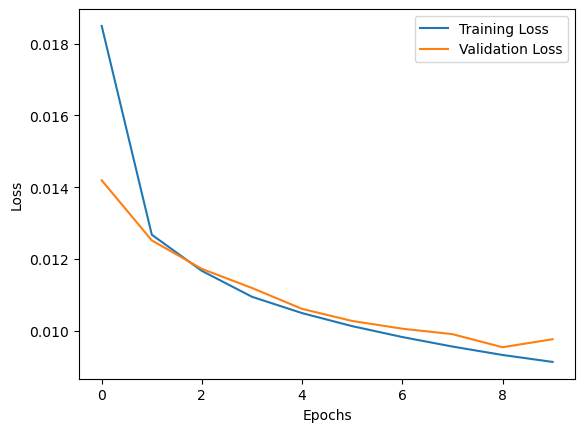

In [21]:
history = autoencoder.fit(train_dataset,
                          validation_data=validation_dataset,
                          epochs=10,
                          batch_size=32
                          )


# Evaluate performance (you may use a validation set or a separate test set)
loss = autoencoder.evaluate(test_dataset, verbose=1)


# Access the training history
loss = history.history['loss']
val_loss = history.history['val_loss']


# Plot the training progress
import matplotlib.pyplot as plt

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 134ms/step


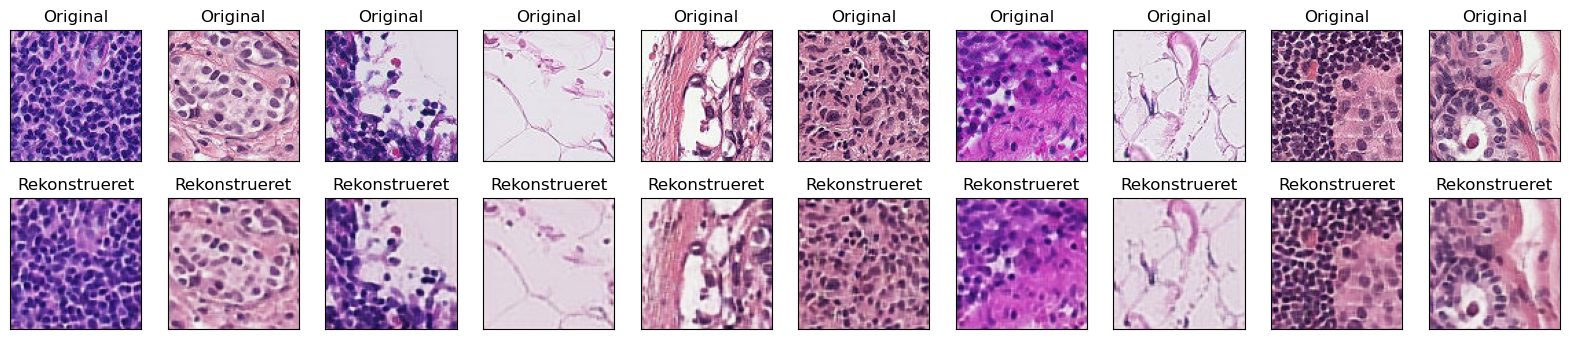

Mean Squared Error: 0.009411810897290707


In [22]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Antal billeder at vise
n = 10

# Hent nogle eksempler fra testdatasættet
samples = next(iter(test_dataset))[0][:n]  # Brug kun inputbilleder

# Generer rekonstruerede billeder fra de originale billeder
reconstructed_images = autoencoder.predict(samples)

plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.title("Original")
    plt.imshow(tf.squeeze(samples[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display rekonstruktion
    bx = plt.subplot(2, n, i + 1 + n)
    plt.title("Rekonstrueret")
    plt.imshow(tf.squeeze(reconstructed_images[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

plt.show()

from sklearn.metrics import mean_squared_error
import tensorflow as tf

# Assuming 'samples' contains original images and 'reconstructed_images' contains corresponding reconstructed images

# Reshape the arrays to 2D (flatten each image)
samples_flat = tf.reshape(samples, (samples.shape[0], -1))
reconstructed_flat = tf.reshape(reconstructed_images, (reconstructed_images.shape[0], -1))

# Convert EagerTensor to numpy arrays
samples_flat = samples_flat.numpy()
reconstructed_flat = reconstructed_flat.numpy()

# Calculate Mean Squared Error
mse = mean_squared_error(samples_flat, reconstructed_flat)
print(f"Mean Squared Error: {mse}")



In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Reshape, Conv2DTranspose, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# Define the sampling function
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Encoder
latent_dim = 64  # Size of the latent space

encoder_inputs = tf.keras.Input(shape=(96, 96, 3))
x = Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
x = Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# Decoder
latent_inputs = tf.keras.Input(shape=(latent_dim,))
x = Dense(24 * 24 * 64, activation='relu')(latent_inputs)
x = Reshape((24, 24, 64))(x)
x = Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
decoder_outputs = Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)
decoder = Model(latent_inputs, decoder_outputs, name='decoder')
decoder.summary()

# VAE Model
outputs = decoder(encoder(encoder_inputs)[2])
vae = Model(encoder_inputs, outputs, name='vae')
vae.summary()

# VAE loss function
reconstruction_loss = tf.keras.losses.MeanSquaredError()(encoder_inputs, outputs)
reconstruction_loss *= 96 * 96 * 3
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

# Training the model
vae.fit(train_dataset, epochs=10, validation_data=validation_dataset)


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 48, 48, 32)           896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 24, 24, 64)           18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 36864)                0         ['conv2d_1[0][0]']            
                                                                                            

Epoch 1/10
820/820 [==============================] - 135s 161ms/step - loss: 1158.5638 - val_loss: 1149.2098
Epoch 2/10
820/820 [==============================] - 126s 153ms/step - loss: 1059.8303 - val_loss: 1104.7192
Epoch 3/10
820/820 [==============================] - 156s 191ms/step - loss: 1021.2181 - val_loss: 1080.8331
Epoch 4/10
820/820 [==============================] - 142s 173ms/step - loss: 1007.8964 - val_loss: 1075.4429
Epoch 5/10
820/820 [==============================] - 144s 176ms/step - loss: 998.6639 - val_loss: 1070.7815
Epoch 6/10
820/820 [==============================] - 148s 180ms/step - loss: 993.8613 - val_loss: 1061.7212
Epoch 7/10
820/820 [==============================] - 151s 184ms/step - loss: 990.6376 - val_loss: 1062.2966
Epoch 8/10
820/820 [==============================] - 127s 155ms/step - loss: 988.8119 - val_loss: 1054.4902
Epoch 9/10
820/820 [==============================] - 122s 148ms/step - loss: 987.3789 - val_loss: 1055.0714
Epoch 10/10
820

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Reshape, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K



# Sampling function for the latent space
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# CVAE Model
class CVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()

    def build_encoder(self):
        inputs = Input(shape=(96, 96, 3))
        x = Conv2D(32, 3, activation='relu', strides=2, padding='same')(inputs)
        x = Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
        x = Flatten()(x)
        x = Dense(16, activation='relu')(x)
        z_mean = Dense(self.latent_dim, name='z_mean')(x)
        z_log_var = Dense(self.latent_dim, name='z_log_var')(x)
        z = Lambda(sampling)([z_mean, z_log_var])
        return Model(inputs, [z_mean, z_log_var, z], name='encoder')

    def build_decoder(self):
        latent_inputs = Input(shape=(self.latent_dim,))
        x = Dense(24*24*64, activation='relu')(latent_inputs)
        x = Reshape((24, 24, 64))(x)
        x = Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
        x = Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
        outputs = Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)
        return Model(latent_inputs, outputs, name='decoder')

def call(self, inputs):
    z_mean, z_log_var, z = self.encoder(inputs)
    reconstructed = self.decoder(z)
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    self.add_loss(K.mean(kl_loss) / (96. * 96.))
    return reconstructed


def vae_loss(input_img, output):
    reconstruction_loss = binary_crossentropy(K.flatten(input_img), K.flatten(output))
    reconstruction_loss *= 96 * 96
    total_loss = K.mean(reconstruction_loss)
    return total_loss



def main():
    latent_dim = 2
    cvae = CVAE(latent_dim)
    train_dataset, ds_info = load_pcam_dataset()
    train_dataset = train_dataset.map(lambda x, y: (tf.cast(x, tf.float32) / 255., x))
    train_dataset = train_dataset.batch(32)

optimizer = tf.keras.optimizers.Adam()
cvae.compile(optimizer, loss=vae_loss)

# Train the model
cvae.fit(train_dataset, epochs=10)
if name == "main":
main()